Name- Kanika Maheshwari
Email Id- kanika.physics@gmail.com


The Project consists of Artificial Lunar Landsacpe dataset segmentation using Deep NN structure. For this, we have used Transfer learning, U-net model buiding and optimization, CNN, Callbacks, etc. The evaluation metrics is val_iou_score. So, the basic procedure entails increment of val_iou_score.

In [1]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00


In [2]:
# import the necessary Library

import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf    
import keras
from keras.callbacks import EarlyStopping
from keras.models import Model,load_model
from sklearn.model_selection import train_test_split

Segmentation Models: using `keras` framework.


* Provide environment variable SM_FRAMEWORK=keras / SM_FRAMEWORK=tf.keras before import segmentation_models
* Change framework sm.set_framework('keras') / sm.set_framework('tf.keras')

In [4]:
# Setting framework environment
os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

## Data Preprocessing Pipeline

In [6]:
H = 480 # height of image 
W = 480 # width of image  

## Height and width of the image has been changed to 480 in the place of 256. 
##The size of original image is  720 * 480. when this image is rescaled, there is a some data (features) loss. 
##Therefore increased the value of dimensions to 480*480 instead of 256*256 that was originally provided.

'''This function is used to return the list of path for images and masks in
sorted order from the given directory respectively.'''
# function to return list of image paths and mask paths 
def process_data(IMG_DIR, MASK_DIR):
    images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
    masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

    return images, masks

'''This function is used to return splitted list of images and corresponding 
mask paths in train and test by providing test size.'''
# function to load data and train test split
def load_data(IMG_DIR, MASK_DIR):
    X, y = process_data(IMG_DIR, MASK_DIR)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

'''This function is used to read images. It takes image path as input. 
After reading image it is resized by width and height provide above(480 x 480). 
Next normalization is done by dividing each values with 255. And the result is returned.'''
# function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

'''This function is used to read masks.'''
# function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

'''This function is used to generate tensorflow data pipeline. 
The tensorflow data pipeline is mapped to function ‘preprocess’ .'''
# function for tensorflow dataset pipeline
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

'''This function takes image and mask path. 
It reads the image and mask as provided by paths. 
Mask is one hot encoded for multi class segmentation (here 4 class).'''
# function to read image and mask amd create one hot encoding for mask
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 4, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 4])

    return image, mask

## Load the dataset

In [8]:
'''RENDER_IMAGE_DIR_PATH: ‘Path of image directory’
GROUND_MASK_DIR_PATH: ‘Path of mask directory’

Here load_data function is called. This will load the dataset paths and 
split it into X_train, X_test, y_train, y_test '''

RENDER_IMAGE_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/render'
GROUND_MASK_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/clean'

X_train, X_test, y_train, y_test = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
print(f"Dataset:\n Train: {len(X_train)} \n Test: {len(X_test)}")

Dataset:
 Train: 7812 
 Test: 1954


## Generate tensorflow data pipeline

In [10]:
batch_size = 16 

#batch size of 8 was given by default. 
##The Rule of thumb for a good batch size is 16 or 32 for most computer vision problems.
##To be concise, batch size is more of hit and trial method which works for particular datasets.
##Here, we get best results with batch size 16.

'''Here the tf_dataset function is called will generate the tensorflow data pipeline.'''
# calling tf_dataset
train_dataset = tf_dataset(X_train, y_train, batch=batch_size)
valid_dataset = tf_dataset(X_test, y_test, batch=batch_size)

## Creating U-net Architecture
As per default settings, we used U-net architecture. But that was not very efficient according to the dataset. All the details of experimentation are provided in the document. Thus, we have implemented the Transfer learning technique using VGG-16 as backbone to build the U-net architecture from the pre-trained vgg model.

In [12]:
#Creating a base model 
IMG_SHAPE = (480, 480, 3)

# include_top specify that we don't want to use the fully connected layers (classifier). As pretrained model classifier has more classes.
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#Freezing the base
# Freezing the base
# Freezing prevents the weights in a given layer from being updated during training.
# VGG16 has 16 layers (13 convolutional and 3 Fully connected layers), so setting the entire model's trainable flag to False.

base_model.trainable = False

# The base model architecture
base_model.summary()

# Adding the head

# inputs
inputs = tf.keras.Input(shape=(480, 480, 3))

# base with pretrained model
x = base_model(inputs, training=False)

# classifier layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)

# model
model = tf.keras.Model(inputs, outputs)

# the final model architecture
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 480, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 120, 128)     0     

In [14]:
BACKBONE = 'vgg16'
input_shape = (480, 480, 3)
n_classes = 4
activation = 'softmax'

# using segmentation_models to create U-net with vgg16 as a backbone with pretrained imagenet weights.
# segmentation_model will create a mirror image of our backbone as expansion path and add to the contraction path. Thus creating a U-shape architecture.

model = sm.Unet(backbone_name = BACKBONE, 
                input_shape = input_shape, 
                classes = n_classes, 
                activation = activation,
                encoder_weights = 'imagenet')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 480, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 240, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## Load model and compile


In [16]:
# importing libraries
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping #importing the necessary modules for callbacks
from segmentation_models.metrics import iou_score
import datetime, os

""" Defining Hyperparameters """
img_shape = (480, 480, 3)  
num_classes = 4
lr = 1e-5 #smaller learning rates can  give better generalization
batch_size = 16 #increasing the batch size can provide better performance for larger datasets
epochs = 30 
#Though right number of epochs depend on the complexity of dataset. In this case, 30 epochs are working fine.

""" Model building and compiling """
# metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

#F1 score is the harmonic mean of precision an recall. 
#threshold is used

# compiling the model
model.compile(loss = 'categorical_crossentropy', 
               optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8, decay=1e-6), #epsilon and decay are added as a way to increase the performance. epsilon is a very small number to prevent any division by zero in the implementation. decay helps us to increase performance by reducing the momentum of the optimizer. Adam uses Momentum and Adaptive Learning Rates to converge faster.
               metrics = metrics)
#epsilon  and decay both are very small numbers.
#epsilon is introduced to prevent any division by zero in the implementation. 
#decay reduces the momentum used by Adam optimizer to converge faster and better.

train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size

#converts a date time object to different strings.
#Just to show Date and time of training.
current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

""" Callbacks """
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath=f'models/LunarModel.h5', monitor='val_iou_score', verbose=1, mode='max', save_best_only=True),              
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", mode='max', patience=4, factor=0.1, verbose=1, min_lr=1e-6),                          
        tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=5, verbose=1, mode='max'),  
]
# Create a callback ModelcheckPoint that saves the model periodically as training moves along the number of epochs.
#mode= max represent to maximum val_iou_score. 
#ReduceLROnPlateau callback monitors any quantity, here val_iou_score.
#if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced to min_lr.
#Chosen the patience number randomly. It can be play around.
#EarlyStopping Stops training when a monitored metric (val_iou_score) has stopped improving.

## Train model

In [17]:
'''model.fit is used to train the model'''
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks
        )

2023-01-29 03:07:27.936636: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-29 03:07:33.114718: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


488/488 [==============================] - 863s 2s/step - loss: 0.9906 - iou_score: 0.0250 - f1-score: 0.0434 - val_loss: 0.7003 - val_iou_score: 0.0725 - val_f1-score: 0.1118

Epoch 00001: val_iou_score improved from -inf to 0.07249, saving model to models/LunarModel.h5
Epoch 2/30
488/488 [==============================] - 813s 2s/step - loss: 0.5806 - iou_score: 0.1242 - f1-score: 0.1623 - val_loss: 0.4402 - val_iou_score: 0.1818 - val_f1-score: 0.2101

Epoch 00002: val_iou_score improved from 0.07249 to 0.18180, saving model to models/LunarModel.h5
Epoch 3/30
488/488 [==============================] - 801s 2s/step - loss: 0.4145 - iou_score: 0.2124 - f1-score: 0.2293 - val_loss: 0.3569 - val_iou_score: 0.2298 - val_f1-score: 0.2395

Epoch 00003: val_iou_score improved from 0.18180 to 0.22985, saving model to models/LunarModel.h5
Epoch 4/30
488/488 [==============================] - 801s 2s/step - loss: 0.3151 - iou_score: 0.2344 - f1-score: 0.2419 - val_loss: 0.2760 - val_iou_score:

In [18]:
print(model_history.history)

{'loss': [0.9906250238418579, 0.5806336402893066, 0.4145079553127289, 0.31507110595703125, 0.2499382346868515, 0.22368112206459045, 0.21251854300498962, 0.17179644107818604, 0.13812081515789032, 0.11399713903665543, 0.0983622670173645, 0.08594078570604324, 0.07508404552936554, 0.06532950699329376, 0.05426265671849251, 0.04491189867258072, 0.03766816109418869, 0.03245176747441292, 0.02786419354379177, 0.02421828731894493, 0.021941784769296646, 0.01996861770749092, 0.018944095820188522, 0.018253814429044724, 0.018142886459827423], 'iou_score': [0.02495582588016987, 0.1242092102766037, 0.21236646175384521, 0.23444020748138428, 0.2798292338848114, 0.4873461127281189, 0.4898104965686798, 0.49250346422195435, 0.6127938032150269, 0.7255265712738037, 0.7424266338348389, 0.7591263055801392, 0.7780632972717285, 0.8421605229377747, 0.8927925825119019, 0.9198297262191772, 0.9431997537612915, 0.9646019339561462, 0.9758363962173462, 0.9813362956047058, 0.9829097390174866, 0.9866377115249634, 0.96625

Final training history
{'loss': [0.9906250238418579, 0.5806336402893066, 0.4145079553127289, 0.31507110595703125, 0.2499382346868515, 0.22368112206459045, 0.21251854300498962, 0.17179644107818604, 0.13812081515789032, 0.11399713903665543, 0.0983622670173645, 0.08594078570604324, 0.07508404552936554, 0.06532950699329376, 0.05426265671849251, 0.04491189867258072, 0.03766816109418869, 0.03245176747441292, 0.02786419354379177, 0.02421828731894493, 0.021941784769296646, 0.01996861770749092, 0.018944095820188522, 0.018253814429044724, 0.018142886459827423], 'iou_score': [0.02495582588016987, 0.1242092102766037, 0.21236646175384521, 0.23444020748138428, 0.2798292338848114, 0.4873461127281189, 0.4898104965686798, 0.49250346422195435, 0.6127938032150269, 0.7255265712738037, 0.7424266338348389, 0.7591263055801392, 0.7780632972717285, 0.8421605229377747, 0.8927925825119019, 0.9198297262191772, 0.9431997537612915, 0.9646019339561462, 0.9758363962173462, 0.9813362956047058, 0.9829097390174866, 0.9866377115249634, 0.9662588238716125, 0.9444670677185059, 0.9411133527755737], 'f1-score': [0.0434478260576725, 0.16232910752296448, 0.22927074134349823, 0.241936594247818, 0.2855032682418823, 0.4925130009651184, 0.4945374131202698, 0.4969198405742645, 0.6170098781585693, 0.7294849157333374, 0.7463859915733337, 0.7629410624504089, 0.78188556432724, 0.8459522128105164, 0.8966280817985535, 0.9234717488288879, 0.946688711643219, 0.9681461453437805, 0.979400098323822, 0.9849674105644226, 0.9870157837867737, 0.9923704862594604, 0.9815242886543274, 0.9686340093612671, 0.9665464758872986], 'val_loss': [0.7002739906311035, 0.4402250051498413, 0.35692837834358215, 0.27596673369407654, 0.23267439007759094, 0.2143319696187973, 0.18399649858474731, 0.14977489411830902, 0.12044848501682281, 0.11577378958463669, 0.09446892142295837, 0.07784482836723328, 0.07549215108156204, 0.0590059831738472, 0.05087132751941681, 0.040198247879743576, 0.03652554005384445, 0.030553512275218964, 0.025956958532333374, 0.023290198296308517, 0.021559294313192368, 0.023189546540379524, 0.018791845068335533, 0.018972815945744514, 0.018461788073182106], 'val_iou_score': [0.07248807698488235, 0.18179547786712646, 0.2298465520143509, 0.2393721342086792, 0.4892910122871399, 0.4882642328739166, 0.490739643573761, 0.4911208152770996, 0.6800665259361267, 0.7376781105995178, 0.7414854168891907, 0.740900456905365, 0.7450746893882751, 0.8765833377838135, 0.8647458553314209, 0.975348711013794, 0.9775413274765015, 0.9793404340744019, 0.9870874881744385, 0.990926206111908, 0.9877969622612, 0.988163411617279, 0.9431286454200745, 0.9405394792556763, 0.9403016567230225], 'val_f1-score': [0.11175759881734848, 0.21011312305927277, 0.23947438597679138, 0.24552716314792633, 0.4945099353790283, 0.49299490451812744, 0.49526727199554443, 0.4954635202884674, 0.6842057704925537, 0.7426784634590149, 0.7456579208374023, 0.7453497052192688, 0.7494837641716003, 0.8808215856552124, 0.8687657713890076, 0.9793932437896729, 0.9815168976783752, 0.9834364652633667, 0.9913995265960693, 0.9953583478927612, 0.9927555322647095, 0.9939197301864624, 0.9678205847740173, 0.9661592841148376, 0.9660097360610962], 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-06]}

Lets try the model to new test cases of Lunar Surface images

In [19]:
from skimage.io import imread
from skimage.transform import resize

# function to predict result 
def predict_image(img_path, mask_path, model):
    H = 480
    W = 480
    num_classes = 4

    img = imread(img_path)
    img = img[:480, :480, :]
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask
    mask = imread(mask_path, as_gray = True)
    mask = mask[:480, :480]
    
    ## Prediction
    pred_mask= model.predict(np.expand_dims(img, axis=0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]
    
    
    # calculating IOU score
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)
    
    iou = inter.sum() / union.sum()

    return img, mask, pred_mask, iou

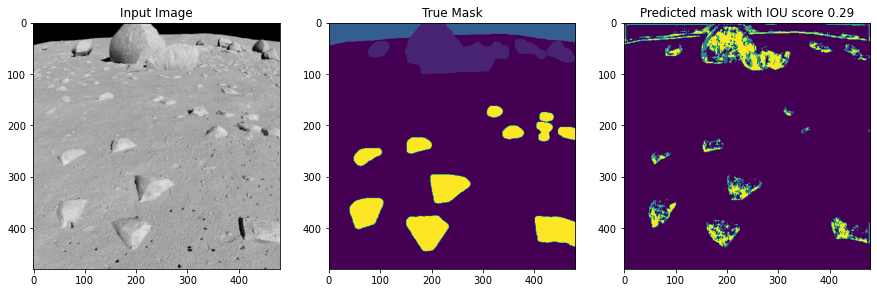

In [40]:
#Using uploading model technique to predict
new_model = sm.Unet(backbone_name = BACKBONE, 
                input_shape = input_shape, 
                classes = n_classes, 
                activation = activation,
                encoder_weights = 'imagenet')

# define the path to the checkpointed model after uploading it
checkpoint_path = '/kaggle/working/models/LunarModel.h5'

#resolve dependencies
dependencies = {
    'iou_score': sm.metrics.IOUScore,
    'f1-score': sm.metrics.FScore
}

# load the weights from the checkpoint
new_model = keras.models.load_model(checkpoint_path, custom_objects=dependencies)
 
# use loaded info for prediction
img_path = '../input/artificial-lunar-rocky-landscape-dataset/images/render/render0036.png'
mask_path = '../input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0036.png'

img, mask, pred_mask, iou = predict_image(img_path, mask_path, new_model)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("True Mask")
ax2.imshow(mask)

ax3.set_title("Predicted mask with IOU score %.2f"%(iou))
ax3.imshow(pred_mask)

plt.show()


### Comparision plots

In [26]:
history_1={'loss': [0.5213340520858765, 0.2776975929737091, 0.17744538187980652, 0.1260780394077301, 0.09197226911783218], 'iou_score': [0.12153264880180359, 0.1600041687488556, 0.18099381029605865, 0.19453856348991394, 0.20648643374443054], 'val_loss': [0.367380291223526, 0.2270708829164505, 0.13354773819446564, 0.10752758383750916, 0.07850208878517151], 'val_iou_score': [0.1417078673839569, 0.17096278071403503, 0.19101212918758392, 0.1991916298866272, 0.21026380360126495]}

history_2={'loss': [0.34790030121803284, 0.17689456045627594, 0.14155925810337067, 0.09714081138372421, 0.07442822307348251, 0.06429019570350647, 0.05338025465607643, 0.04225673899054527, 0.035900235176086426, 0.03182854503393173], 'iou_score': [0.1568373441696167, 0.18756020069122314, 0.1903294324874878, 0.20140418410301208, 0.20190976560115814, 0.20282617211341858, 0.20554152131080627, 0.2086053341627121, 0.21049314737319946, 0.2089906483888626], 'val_loss': [0.17945830523967743, 0.1518033891916275, 0.10454300791025162, 0.09099505841732025, 0.060718223452568054, 0.05448412895202637, 0.048025064170360565, 0.03945820778608322, 0.02724432200193405, 0.028396079316735268], 'val_iou_score': [0.16214178502559662, 0.18673336505889893, 0.1984550654888153, 0.2035779356956482, 0.20509609580039978, 0.20333468914031982, 0.2074781358242035, 0.20905174314975739, 0.21185295283794403, 0.20673316717147827]}

history_3={'loss': [0.7117266654968262, 0.45600977540016174, 0.32547199726104736, 0.2279183566570282, 0.16186082363128662, 0.11996787786483765, 0.11696285754442215, 0.0921688973903656, 0.0718517005443573, 0.05767085403203964], 'iou_score': [0.09559328854084015, 0.1265251636505127, 0.14856009185314178, 0.16742736101150513, 0.181313157081604, 0.19015181064605713, 0.18565881252288818, 0.19315171241760254, 0.1987294852733612, 0.20289762318134308], 'val_loss': [0.535325825214386, 0.3988516330718994, 0.2590702772140503, 0.18397140502929688, 0.13768278062343597, 0.09571881592273712, 0.1234917938709259, 0.07880087196826935, 0.06533107906579971, 0.05109025910496712], 'val_iou_score': [0.11426077783107758, 0.13529102504253387, 0.16133055090904236, 0.176660418510437, 0.18747836351394653, 0.17860347032546997, 0.19018268585205078, 0.19373475015163422, 0.19897028803825378, 0.20525702834129333]}

history_4={'loss': [0.9049280285835266, 0.7006381154060364, 0.6089666485786438, 0.5537729859352112, 0.5121384859085083, 0.4773394465446472, 0.45194780826568604, 0.41768547892570496, 0.39186814427375793, 0.36591270565986633, 0.3490155041217804, 0.32391101121902466, 0.30496543645858765, 0.29066038131713867, 0.27206945419311523, 0.2520412504673004, 0.23974169790744781, 0.22138196229934692, 0.20845814049243927, 0.19604651629924774], 'iou_score': [0.07836165279150009, 0.0988791435956955, 0.11018751561641693, 0.11877691000699997, 0.12487923353910446, 0.12993773818016052, 0.13432085514068604, 0.13957670331001282, 0.14427103102207184, 0.14862452447414398, 0.15215745568275452, 0.15614347159862518, 0.1596854329109192, 0.16310013830661774, 0.1665724664926529, 0.17019249498844147, 0.17312869429588318, 0.1763029843568802, 0.17909137904644012, 0.18188154697418213], 'val_loss': [0.6381720304489136, 0.6460586786270142, 0.5842065215110779, 0.5314304828643799, 0.4935382604598999, 0.46508705615997314, 0.438394695520401, 0.4035232365131378, 0.39203938841819763, 0.3558117747306824, 0.3578684329986572, 0.31670209765434265, 0.29493334889411926, 0.277129590511322, 0.2573677599430084, 0.23772303760051727, 0.22362840175628662, 0.21067148447036743, 0.19896705448627472, 0.18559859693050385], 'val_iou_score': [0.10832564532756805, 0.10551607608795166, 0.1151934564113617, 0.12145157158374786, 0.128128781914711, 0.13308119773864746, 0.13702742755413055, 0.14178015291690826, 0.1458437144756317, 0.1509494036436081, 0.15305103361606598, 0.15811578929424286, 0.16181634366512299, 0.1651749312877655, 0.16835461556911469, 0.17255008220672607, 0.17532959580421448, 0.17886868119239807, 0.18099474906921387, 0.18381427228450775]}

history_5={'loss': [0.7167102098464966, 0.41489988565444946, 0.29653090238571167, 0.21519821882247925, 0.1521640568971634, 0.11162208020687103, 0.08345136046409607, 0.06376221776008606, 0.055020805448293686, 0.05156851187348366, 0.04477851465344429, 0.03723257780075073, 0.035095442086458206, 0.03452696278691292, 0.029606392607092857, 0.02537420764565468, 0.02239924483001232, 0.02009744383394718, 0.018356118351221085, 0.016838183626532555], 'iou_score': [0.09703512489795685, 0.13710898160934448, 0.15640626847743988, 0.17700333893299103, 0.19177702069282532, 0.20180588960647583, 0.20908699929714203, 0.21345698833465576, 0.21292369067668915, 0.21001173555850983, 0.21169023215770721, 0.21347221732139587, 0.2086569368839264, 0.20465661585330963, 0.20803745090961456, 0.20973166823387146, 0.21055519580841064, 0.21091505885124207, 0.21145716309547424, 0.2118251621723175], 'val_loss': [0.5149352550506592, 0.3519676625728607, 0.23983648419380188, 0.16519616544246674, 0.1684006303548813, 0.09057986736297607, 0.06938844919204712, 0.05366033688187599, 0.09277140349149704, 0.04128580167889595, 0.03842133283615112, 0.03417607769370079, 0.031515445560216904, 0.02739088423550129, 0.029056908562779427, 0.06405059248209, 0.05153995007276535, 0.06179880350828171, 0.03917035460472107, 0.026170406490564346], 'val_iou_score': [0.11834517121315002, 0.14650994539260864, 0.15490545332431793, 0.18347829580307007, 0.19531811773777008, 0.20763523876667023, 0.2111082673072815, 0.21604476869106293, 0.2069012075662613, 0.2035258263349533, 0.2116321325302124, 0.21282973885536194, 0.19800880551338196, 0.19760236144065857, 0.20675890147686005, 0.20102931559085846, 0.20468810200691223, 0.20135283470153809, 0.20735161006450653, 0.2012489289045334]}

history_6={'loss': [0.180782288312912, 0.029010562226176262, 0.024075577035546303, 0.030319642275571823, 0.017926819622516632, 0.018826372921466827, 0.025703564286231995, 0.01981928013265133, 0.012579532340168953, 0.029820213094353676], 'iou_score': [0.21324346959590912, 0.23308876156806946, 0.20878051221370697, 0.19066143035888672, 0.1901731938123703, 0.19004540145397186, 0.19033442437648773, 0.19014695286750793, 0.1899462193250656, 0.19245824217796326], 'f1-score': [0.225984126329422, 0.24110911786556244, 0.2269245684146881, 0.21626406908035278, 0.21585145592689514, 0.21590393781661987, 0.21599426865577698, 0.21615993976593018, 0.21578970551490784, 0.21729329228401184], 'val_loss': [0.03259531781077385, 0.02184586599469185, 0.0318148247897625, 0.06107906252145767, 0.03782820329070091, 0.01089067105203867, 0.022709911689162254, 0.01338899414986372, 0.029865365475416183, 0.03751753643155098], 'val_iou_score': [0.2365386039018631, 0.2337999790906906, 0.1897459477186203, 0.19004298746585846, 0.18955552577972412, 0.18943485617637634, 0.189523383975029, 0.18951675295829773, 0.18942902982234955, 0.19948306679725647], 'val_f1-score': [0.24308237433433533, 0.24158331751823425, 0.21551135182380676, 0.21634678542613983, 0.21553978323936462, 0.21536041796207428, 0.2156134843826294, 0.21549753844738007, 0.21536828577518463, 0.22176295518875122]}

history_7={'loss': [0.28338003158569336, 0.04610634222626686, 0.024996906518936157, 0.02050204575061798, 0.019564801827073097, 0.014946446754038334, 0.023872748017311096, 0.013258332386612892, 0.010219504125416279, 0.008441649377346039, 0.07094893604516983, 0.400527685880661, 0.37697634100914, 0.3656800389289856, 0.3596500754356384], 'iou_score': [0.40451791882514954, 0.4666329622268677, 0.42271891236305237, 0.36325687170028687, 0.3589547872543335, 0.3516804873943329, 0.4494393765926361, 0.4359055459499359, 0.4297538101673126, 0.405553936958313, 0.4656516909599304, 0.15217866003513336, 0.21480797231197357, 0.3102456331253052, 0.30915147066116333], 'f1-score': [0.41469526290893555, 0.4745403528213501, 0.4317133128643036, 0.3751528561115265, 0.37895673513412476, 0.375825434923172, 0.47463858127593994, 0.46118152141571045, 0.4548373222351074, 0.43069401383399963, 0.4871598184108734, 0.18615056574344635, 0.25022947788238525, 0.3439835011959076, 0.34194234013557434], 'val_loss': [0.060378581285476685, 0.028961481526494026, 0.024058641865849495, 0.029985103756189346, 0.01756584458053112, 0.015638522803783417, 0.014568804763257504, 0.00875175278633833, 0.0069892629981040955, 0.004806580953299999, 0.11912316083908081, 0.29506903886795044, 0.25355151295661926, 0.2537301182746887, 0.27988073229789734], 'val_iou_score': [0.5423741936683655, 0.44353848695755005, 0.19661131501197815, 0.66239333152771, 0.43184295296669006, 0.6775591969490051, 0.44000449776649475, 0.43994009494781494, 0.43793052434921265, 0.6898601651191711, 0.2508809566497803, 0.20706667006015778, 0.4158976078033447, 0.4318417012691498, 0.4037080705165863], 'val_f1-score': [0.5615599751472473, 0.46801406145095825, 0.22179020941257477, 0.688061535358429, 0.4575421214103699, 0.7033166289329529, 0.46571266651153564, 0.4656669497489929, 0.4636598229408264, 0.715634822845459, 0.27570417523384094, 0.2409362643957138, 0.4465752840042114, 0.4599939286708832, 0.4320240616798401], 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-05]}

history_8=  {'loss': [0.9906250238418579, 0.5806336402893066, 0.4145079553127289, 0.31507110595703125, 0.2499382346868515, 0.22368112206459045, 0.21251854300498962, 0.17179644107818604, 0.13812081515789032, 0.11399713903665543, 0.0983622670173645, 0.08594078570604324, 0.07508404552936554, 0.06532950699329376, 0.05426265671849251, 0.04491189867258072, 0.03766816109418869, 0.03245176747441292, 0.02786419354379177, 0.02421828731894493, 0.021941784769296646, 0.01996861770749092, 0.018944095820188522, 0.018253814429044724, 0.018142886459827423], 'iou_score': [0.02495582588016987, 0.1242092102766037, 0.21236646175384521, 0.23444020748138428, 0.2798292338848114, 0.4873461127281189, 0.4898104965686798, 0.49250346422195435, 0.6127938032150269, 0.7255265712738037, 0.7424266338348389, 0.7591263055801392, 0.7780632972717285, 0.8421605229377747, 0.8927925825119019, 0.9198297262191772, 0.9431997537612915, 0.9646019339561462, 0.9758363962173462, 0.9813362956047058, 0.9829097390174866, 0.9866377115249634, 0.9662588238716125, 0.9444670677185059, 0.9411133527755737], 'f1-score': [0.0434478260576725, 0.16232910752296448, 0.22927074134349823, 0.241936594247818, 0.2855032682418823, 0.4925130009651184, 0.4945374131202698, 0.4969198405742645, 0.6170098781585693, 0.7294849157333374, 0.7463859915733337, 0.7629410624504089, 0.78188556432724, 0.8459522128105164, 0.8966280817985535, 0.9234717488288879, 0.946688711643219, 0.9681461453437805, 0.979400098323822, 0.9849674105644226, 0.9870157837867737, 0.9923704862594604, 0.9815242886543274, 0.9686340093612671, 0.9665464758872986], 'val_loss': [0.7002739906311035, 0.4402250051498413, 0.35692837834358215, 0.27596673369407654, 0.23267439007759094, 0.2143319696187973, 0.18399649858474731, 0.14977489411830902, 0.12044848501682281, 0.11577378958463669, 0.09446892142295837, 0.07784482836723328, 0.07549215108156204, 0.0590059831738472, 0.05087132751941681, 0.040198247879743576, 0.03652554005384445, 0.030553512275218964, 0.025956958532333374, 0.023290198296308517, 0.021559294313192368, 0.023189546540379524, 0.018791845068335533, 0.018972815945744514, 0.018461788073182106], 'val_iou_score': [0.07248807698488235, 0.18179547786712646, 0.2298465520143509, 0.2393721342086792, 0.4892910122871399, 0.4882642328739166, 0.490739643573761, 0.4911208152770996, 0.6800665259361267, 0.7376781105995178, 0.7414854168891907, 0.740900456905365, 0.7450746893882751, 0.8765833377838135, 0.8647458553314209, 0.975348711013794, 0.9775413274765015, 0.9793404340744019, 0.9870874881744385, 0.990926206111908, 0.9877969622612, 0.988163411617279, 0.9431286454200745, 0.9405394792556763, 0.9403016567230225], 'val_f1-score': [0.11175759881734848, 0.21011312305927277, 0.23947438597679138, 0.24552716314792633, 0.4945099353790283, 0.49299490451812744, 0.49526727199554443, 0.4954635202884674, 0.6842057704925537, 0.7426784634590149, 0.7456579208374023, 0.7453497052192688, 0.7494837641716003, 0.8808215856552124, 0.8687657713890076, 0.9793932437896729, 0.9815168976783752, 0.9834364652633667, 0.9913995265960693, 0.9953583478927612, 0.9927555322647095, 0.9939197301864624, 0.9678205847740173, 0.9661592841148376, 0.9660097360610962], 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-06]}

In [27]:
# visulization code
import matplotlib.pyplot as plt
def Plot(history1, history2):
        plt.plot(history1['val_iou_score'])
        plt.plot(history2['val_iou_score'])
        plt.title('Model Performance')
        plt.xlabel('epochs')
        plt.ylabel('val_iou_score')
        plt.legend(['Val_iou_score of Cycle 1', 'Val_iou_score of cycle 2'])
        plt.show()

In [28]:
# import module to create tables in Python
from tabulate import tabulate
def Table(history1,history2): 
    
    his_data = [
        [history1, history2]
    ]

    
    head = ["Cycle 1", "Cycle 2"]

    # display table
    print(tabulate(his_data, headers=head, tablefmt="plain"))

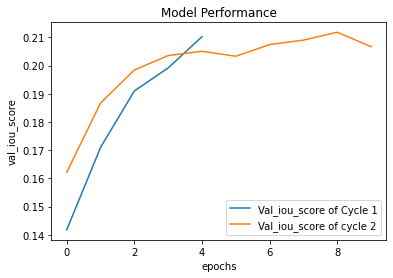


  Cycle 1    Cycle 2
 0.210264   0.206733



In [29]:
#Plot for impact of epochs on val_iou_score of basic U-net architecture
Plot(history_1,history_2)
print()
Table(history_1["val_iou_score"][-1],history_2["val_iou_score"][-1])
print()

The score is slightly decreased due to increment of epochs. 

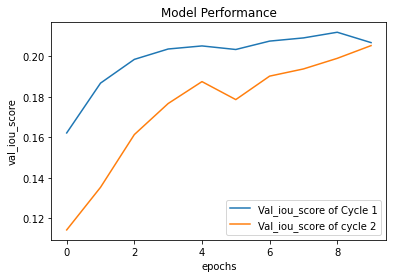


  Cycle 1    Cycle 2
 0.206733   0.205257



In [30]:
#impact of learning rate decrement on val_iou_score of basic U-net architecture
Plot(history_2,history_3)
print()
Table(history_2["val_iou_score"][-1],history_3["val_iou_score"][-1])
print()

Due to learning rate, scores are almost equal after epochs.

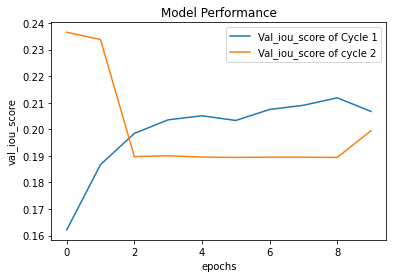


  Cycle 1    Cycle 2
 0.206733   0.199483



In [32]:
#impact on val_iou_score with using transfer learning
Plot(history_2,history_6)
print()
Table(history_2["val_iou_score"][-1],history_6["val_iou_score"][-1])
print()

Score are decreased a bit when transfer learning is introduced. this could be due to insufficient batch size and number of epochs.

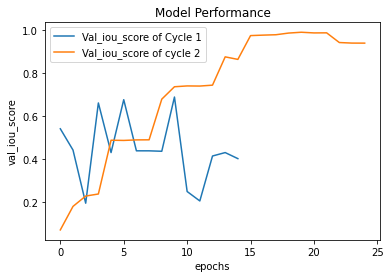


  Cycle 1    Cycle 2
 0.403708   0.940302



In [33]:
#Plot to show impact of inceasing epochs on VGG16 model
Plot(history_7,history_8)
print()
Table(history_7["val_iou_score"][-1],history_8["val_iou_score"][-1])
print()

The effect of increase number of epochs is clearly visible.

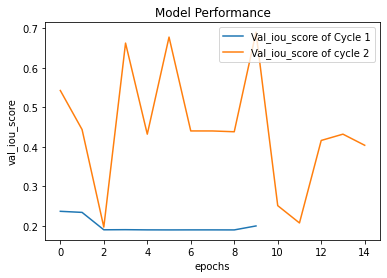


  Cycle 1    Cycle 2
 0.199483   0.403708



In [35]:
#Impact of batch size on VGG 16 model
Plot(history_6,history_7)
print()
Table(history_6["val_iou_score"][-1],history_7["val_iou_score"][-1])
print()

The summarized document with references can be find with this link below-
https://docs.google.com/document/d/1RLtnQ8EF2qgiUmx38p-mIXemzDO0HUEe/edit?usp=sharing&ouid=102344113228896258884&rtpof=true&sd=true